In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1)
import warnings
warnings.filterwarnings('ignore')

# А. Импорт данных.

In [33]:
pasport_file = 'structure-20151111.csv'
df_passport = pd.read_csv(pasport_file, sep=';', encoding='cp1251')

In [34]:
df_passport

,Наименование поля,Англоязычное наименование,Описание поля,Тип поля,Уник.,Обязат.,Длина,Колич. Знаков после запятой,Связь с другой таблицей (название таблицы и поле связи)
0,Год,Year,Отчетный год,Числовое,нет,да,4,NaN,NaN
1,Период,Period,Отчетный месяц,Числовое,нет,да,2,NaN,NaN
2,МВЛ,MVL,Местные воздушные линии,Числовое,нет,да,10,NaN,NaN
3,ДЗ,DZ,Дальнее зарубежье,Числовое,нет,да,10,NaN,NaN
4,СНГ,SNG,Содружество независимых государств,Числовое,нет,да,10,NaN,NaN
5,Внутренние,Inner,Внутренние перевозки,Числовое,нет,да,10,NaN,NaN
6,Местные,Current,Местные перевозки,Числовое,нет,да,10,NaN,NaN
7,Итого,Total,Суммарно по всем полям,Числовое,нет,да,10,NaN,NaN


### Чтение данных
На первоначальном этапе изменим названия колонок на английский язык и запишим их в нижнем регистре, что сэкономить время на смену раскладки и переключения в верхний регистр, а также позволит избежать возможных ошибок связанных с кодировкой во время обрабоки данных. Также переведем дату в формат `datetime`.

In [4]:
eng_col_names = (st.lower() for st in df_passport['Англоязычное наименование'])
data_file = 'data-20210201-structure-20151111.csv'
df = pd.read_csv(data_file, sep=';', thousands=' ', encoding='cp1251')
df.rename(columns=(dict(zip(df.columns, eng_col_names))), inplace=True)
df['date'] = pd.to_datetime([f'{y}{m}' for y, m in zip(df.year, df.period)], format='%Y%m')

#### Замечание
По каким то причинам значение   `Итого` не соответствует сумме значений в остальных полях, как это заявлено в паспорте.

Возможно есть какие то неучтенные колонки с доходами или колонка `Затраты`.

На этом этапе создадим колонку `True_total` отражающую действительную сумму по остальным полям и рассчитаем отношение колонки `Итого` к `true_total` как `ratio` просто из интереса.

In [5]:
df['true_total'] = df[['mvl', 'dz', 'sng', 'inner', 'current']].sum(axis=1)
df['ratio'] = df['total'] / df['true_total']

#### Выберем только интересующий нас период 2015 - 2018

In [6]:
df_full = df.copy()
df = df[(2015 <= df.year) & (df.year <= 2018)].reset_index(drop=True)

In [7]:
df.head(3)

,year,period,mvl,dz,sng,inner,current,total,date,true_total,ratio
0,2015,1,2719771,2139659,580112,3160127,96564,5879898,2015-01-01,8696233,0.676143
1,2015,2,2151636,1629675,521961,2961237,95808,5112873,2015-02-01,7360317,0.694654
2,2015,3,2551966,1979626,572340,3432363,123620,5984329,2015-03-01,8659915,0.691038


In [8]:
df.tail(3)

,year,period,mvl,dz,sng,inner,current,total,date,true_total,ratio
45,2018,10,4281389,3594871,686518,5718181,153431,9999570,2018-10-01,14434390,0.692760
46,2018,11,3339643,2700355,639288,5220762,158406,8560405,2018-11-01,12058454,0.709909
47,2018,12,3265543,2634927,630616,5186518,150710,8452061,2018-12-01,11868314,0.712153


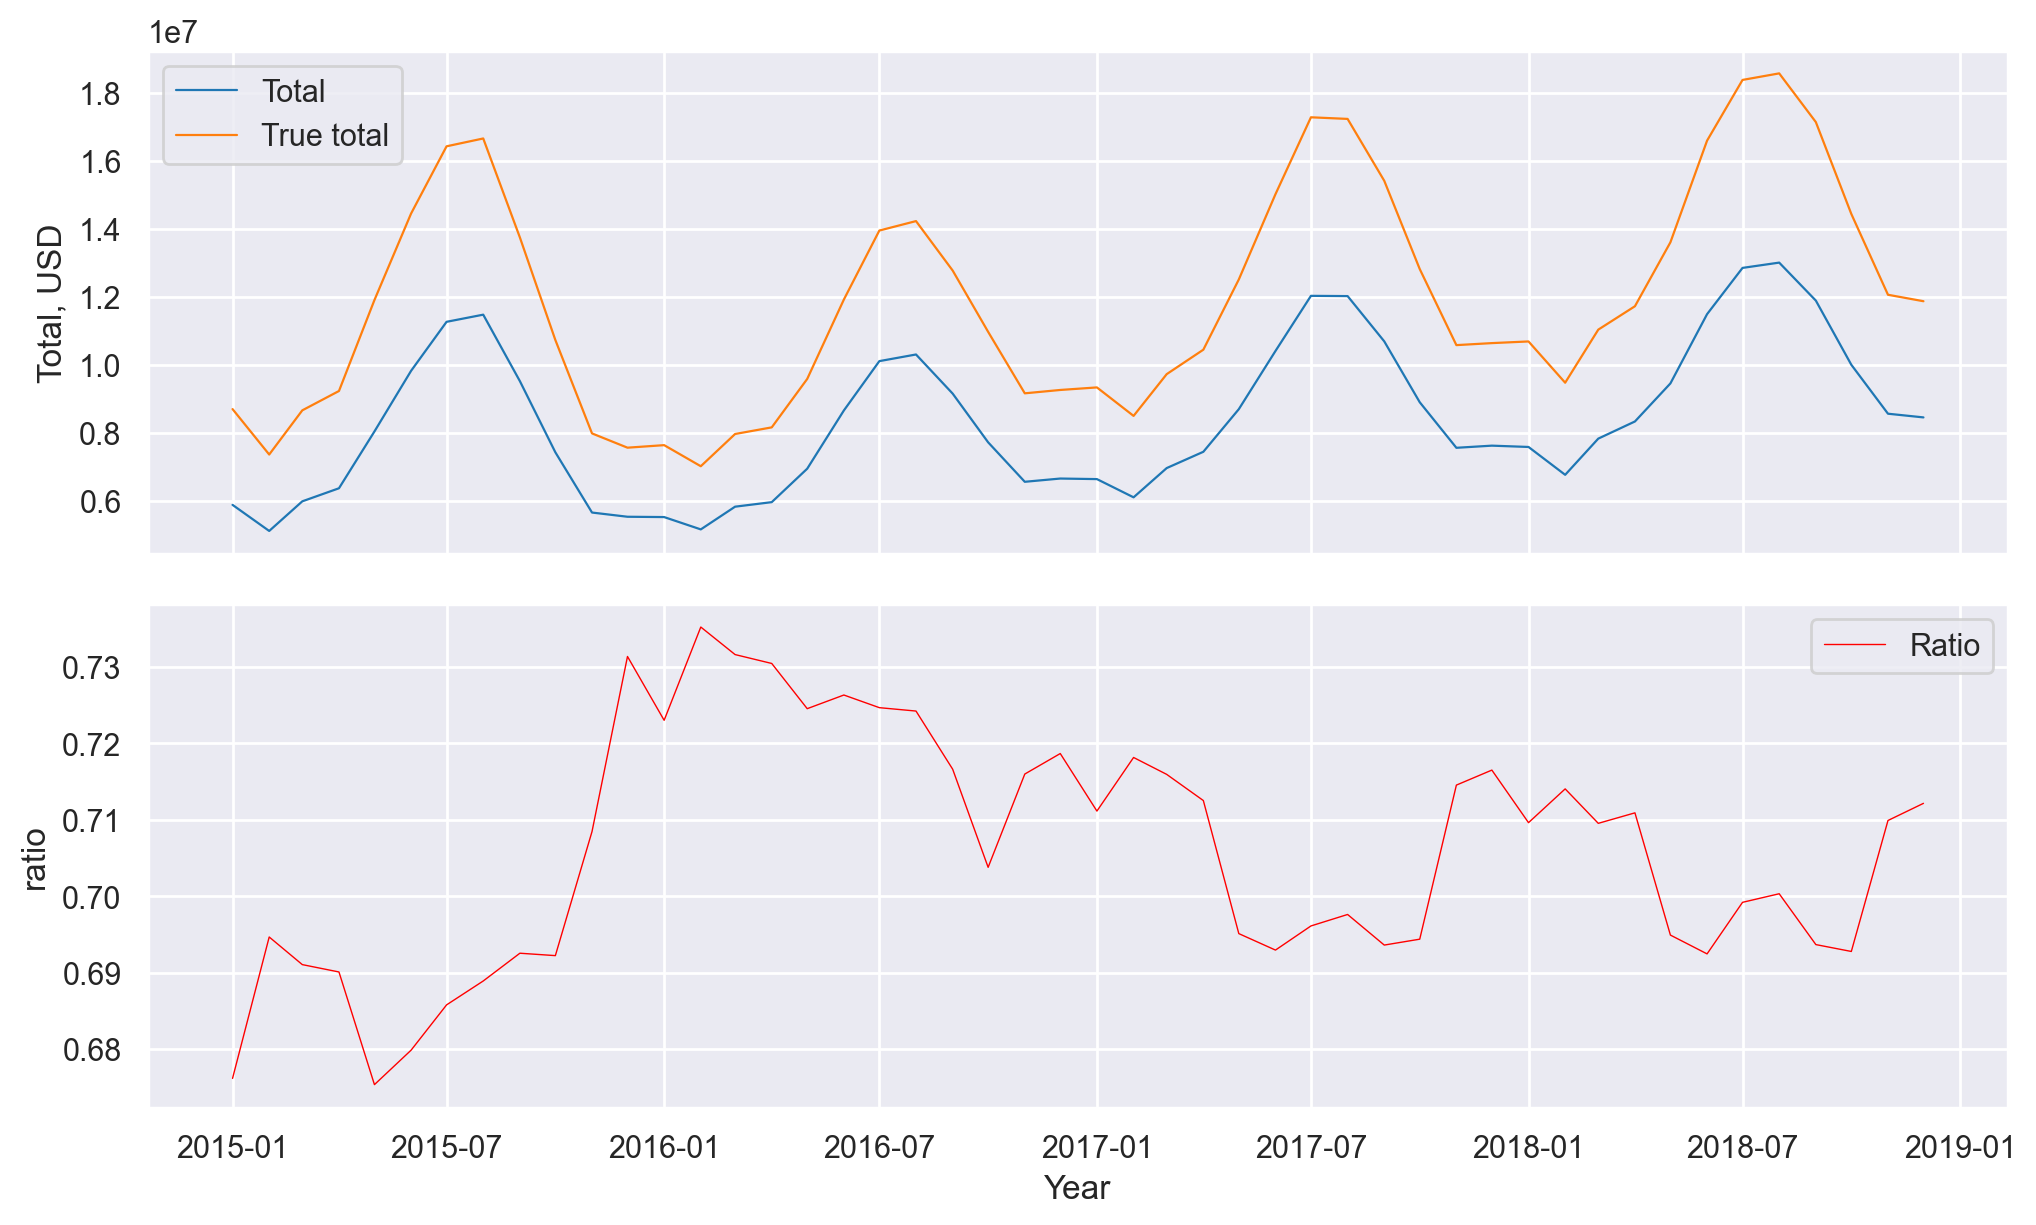

In [9]:
fig, axs = plt.subplots(ncols=1, nrows = 2, figsize=(12,7), sharex=True, dpi=200)
fig.subplots_adjust(hspace=0.1)
sns.lineplot(x = df.date, y=df.total, ax=axs[0], linewidth=.8, label='Total')
sns.lineplot(x = df.date, y=df.true_total, ax=axs[0], linewidth=.8, label='True total')
axs[0].set_ylabel('Total, USD')
sns.lineplot(x=df.date, y=df.ratio, color='r', ax=axs[1], linewidth=.5, label='Ratio')
axs[1].set_xlabel('Year')
plt.show()

---

# B. Обработка данных. 

### B1 Построение 3-месячного скользящего среднего

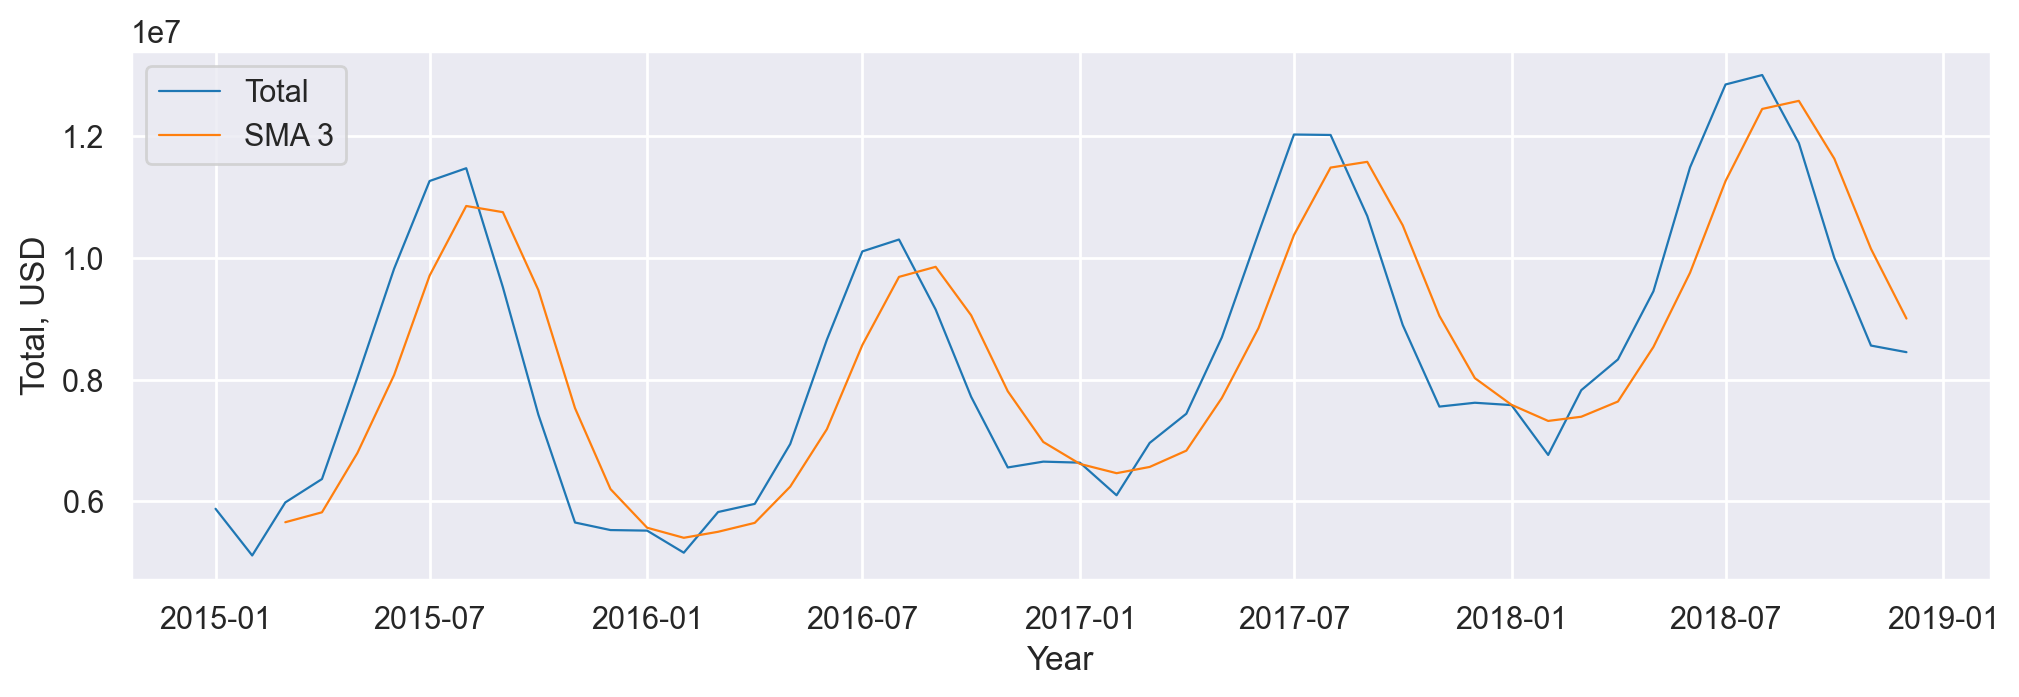

In [10]:
df['sma_3'] = df.total.rolling(3).mean() # 3-month simple moving avarage
plt.figure(figsize=(12,3.5), dpi=200)
sns.lineplot(x = df.date, y=df.total, linewidth=.8, label='Total')
sns.lineplot(x = df.date, y=df.sma_3, linewidth=.8, label='SMA 3')
plt.ylabel('Total, USD')
plt.xlabel('Year')
plt.show()

### B2 Построение сезонного графика для периода 2015 - 2019 г.

В `Season_decompose` на выбор предлагается аддитивная или мультипликативная модель. Практическое правило выбора правильной модели - увидеть на нашем графике, являются ли тренд и сезонные колебания относительно постоянными во времени, другими словами, линейными. Если да, то выберем аддитивную модель. В противном случае, если тренд и сезонная вариация увеличиваются или уменьшаются со временем, мы используем мультипликативную модель.
Наши данные здесь агрегированы по месяцам. Период, который мы хотим проанализировать, - это год, поэтому мы установили период на 12 мес.

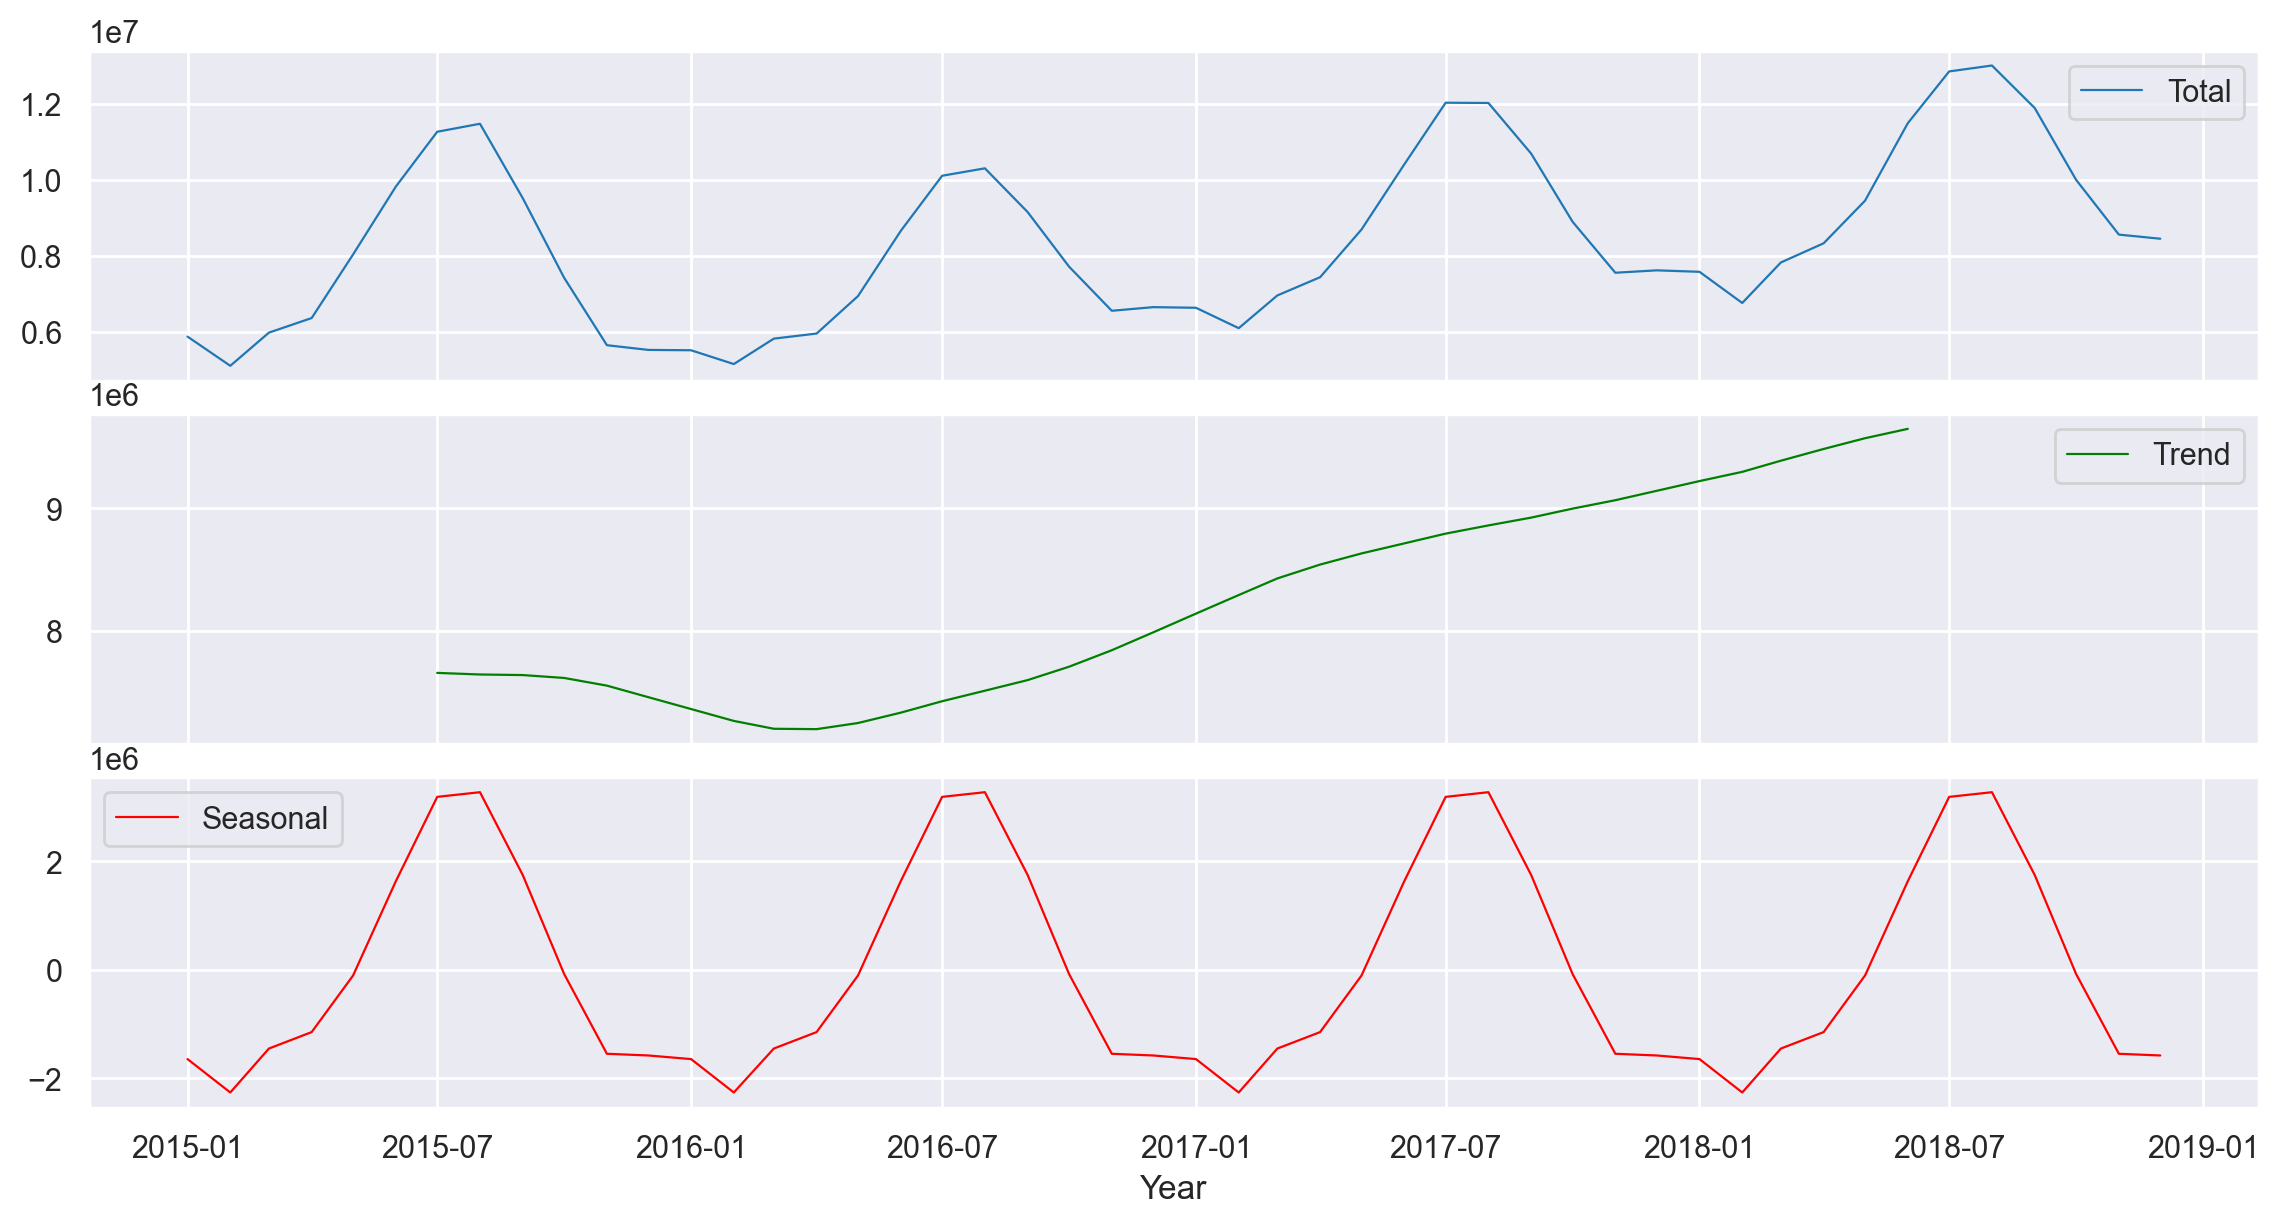

In [11]:
import statsmodels.api as sm

decomposed_ts = sm.tsa.seasonal_decompose(df.total, model = 'additive', freq=12)
seasonal_ts = decomposed_ts.seasonal.values
trend_ts = decomposed_ts.trend.values
fig, axs = plt.subplots(ncols=1, nrows = 3, figsize=(14,7), sharex=True, dpi=200)
fig.subplots_adjust(hspace=0.1)
sns.lineplot(x = df.date, y=df.total, linewidth=.8, ax=axs[0], label='Total')
axs[0].set_ylabel('')
sns.lineplot(x = df.date, y=trend_ts, linewidth=.8, ax=axs[1], color='g', label = 'Trend')
sns.lineplot(x = df.date, y=seasonal_ts, linewidth=.8, ax=axs[2], color='r', label='Seasonal')
axs[2].set_xlabel('Year')
plt.show()

На построенном сезонном графике видна ярко выраженная периодичность с максимум приходящимсся на летние месяцы с `Июля` - `Август`, что скорее всего, объясняется периодом отпусков. `Минимумы` приходятся на осенне-зимний период `Ноября - Февраль`.

---

# C. Прогнозирование временных рядов.
Используя полученные среднемесячные данные за период `2015-2018 гг`. предложить любую адекватную прогнозную модель на `2019г`.
Отдельно описать основные этапы построения модели (выбор метода, подбор параметров, оценка качества модели).

# C1 
Учитывая сильно-выраженную сезонность рассчитываемого значения и практически линейно восходящий тренд, наиболее простой моделью видится построение линейной регрессии для линии тренда с последующей поправкой на сезонность, которую мы будем считать постоянной. Иными словами находить итоговое значение как сумму `линия тренда` + `постоянная сезонность`. 

In [12]:
import scipy.stats as sp
from datetime import datetime

In [13]:
X = np.array((df.date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')) # time to unix format
X = X[6:-6]
y = trend_ts[6:-6]
slope, intercept, r_value, p_value, std_err = sp.linregress(X, y)
linear_fit = (slope * X) + intercept

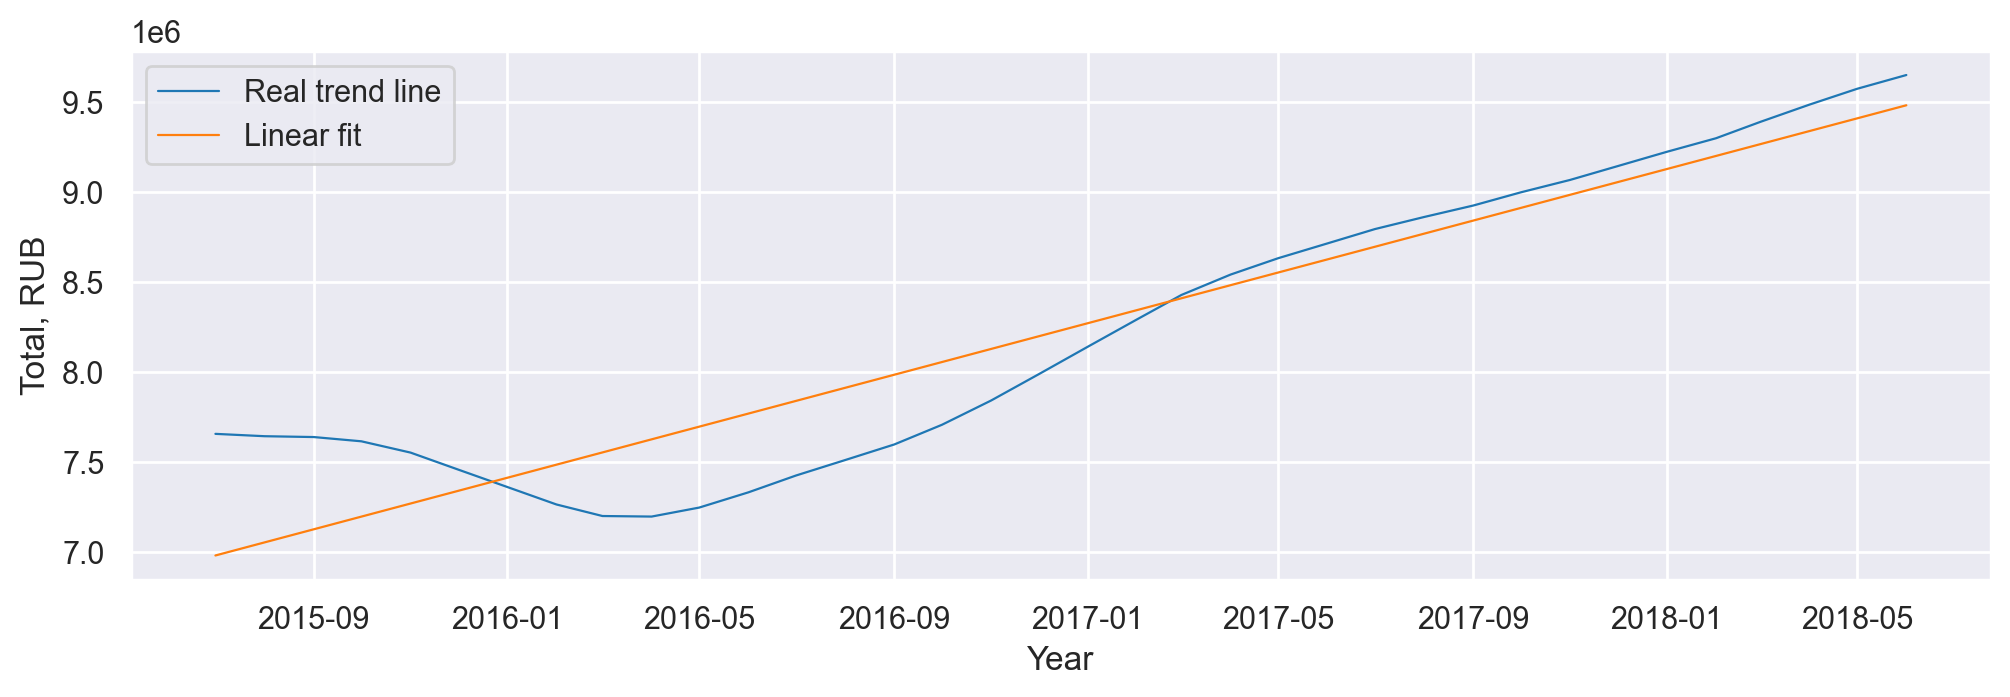

In [14]:
plt.figure(figsize=(12,3.5), dpi=200)
sns.lineplot(x = df.date[6:-6], y = y, linewidth=.8, label='Real trend line')
sns.lineplot(x = df.date[6:-6], y = linear_fit, linewidth=.8, label='Linear fit')
plt.ylabel('Total, RUB')
plt.xlabel('Year')
plt.show()

В данном случае мы предсказываем только линейную часть временного ряда. Считаем что сезонная часть постоянна для каждого года, создадим переменную `one_year_pattern` которая бы содержала сезонные изменения за период в 12 месяцев.

In [15]:
one_year_pattern = seasonal_ts[:12]

#### Теперь просто сложим линейную часть предсказанную для 4 лет (2015-2018) полученную линейной регрессией с годовым сезонным паттерном взятым 4 раза.

In [16]:
X = np.array((df.date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))
linear_fit = (slope * X) + intercept
seasonal_part = np.tile(one_year_pattern, int(len(linear_fit) / 12))
total_linear_model = linear_fit + seasonal_part

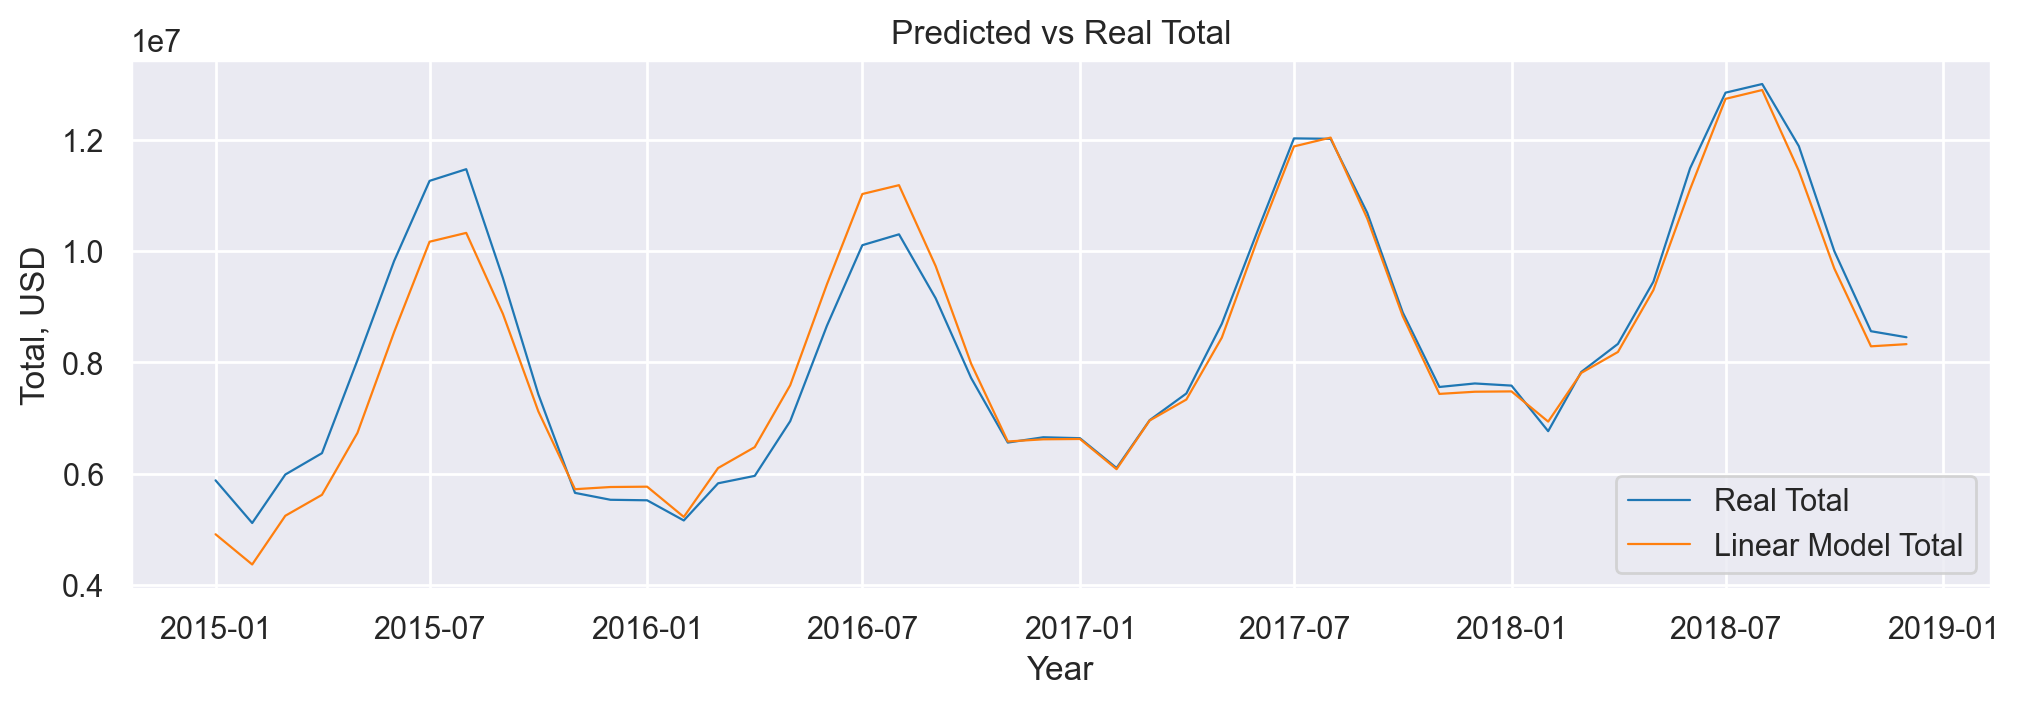

In [17]:
plt.figure(figsize=(12,3.5), dpi=200)
sns.lineplot(x = df.date, y = df.total, linewidth=.8, label='Real Total')
sns.lineplot(x = df.date, y = total_linear_model, linewidth=.8, label='Linear Model Total')
plt.ylabel('Total, USD')
plt.xlabel('Year')
plt.title('Predicted vs Real Total')
plt.show()

#### Оценим значение RMSE, R2 и max error для построенной модели на период 2015 - 2018 гг.

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error

def calculate_errors(y_true : list, y_pred : list) -> str:
    textstr = f'Max error  : {max_error(y_true, y_pred):.0f}\nRMSE       : {mean_squared_error(y_true, y_pred, squared=False):.0f}\nR2             : {r2_score(y_true, y_pred):.2f}'
    return textstr

In [19]:
print(calculate_errors(y_true = df.total, y_pred = total_linear_model))

Max error  : 1306035
RMSE       : 525076
R2             : 0.94


#### Значение $R2$ и $RMSE$, позволяют судить об удовлетворительном качестве модели. Построим прогноз на 2019 год.

In [20]:
df_2019 = df_full[df_full.year == 2019]

In [21]:
df_2019

,year,period,mvl,dz,sng,inner,current,total,date,true_total,ratio
216,2019,1,3376071,2895185,480886,4956442,120695,8332513,2019-01-01,11829279,0.704397
217,2019,2,2968260,2528240,440020,4520838,117423,7489098,2019-02-01,10574781,0.708204
218,2019,3,3599265,3081189,518076,5322947,142861,8922212,2019-03-01,12664338,0.704515
219,2019,4,3855027,3327913,527114,5510223,154580,9365250,2019-04-01,13374857,0.700213
220,2019,5,4972077,4420891,551186,5963745,170545,10935822,2019-05-01,16078444,0.680154
221,2019,6,5710945,5138680,572265,6911136,186130,12622081,2019-06-01,18519156,0.681569
222,2019,7,6223963,5641971,581992,7996175,205914,14220138,2019-07-01,20650015,0.688626
223,2019,8,6328996,5758276,570720,8101595,213806,14430591,2019-08-01,20973393,0.688043
224,2019,9,5831715,5299556,532159,6992252,170826,12823967,2019-09-01,18826508,0.681165
225,2019,10,5112414,4601757,510657,6032368,163064,11144782,2019-10-01,16420260,0.678721


In [22]:
X_2019 = np.array((df_2019.date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')) # time to unix format
y_2019 = (slope * X_2019) + intercept
total_2019_pred = y_2019 + one_year_pattern

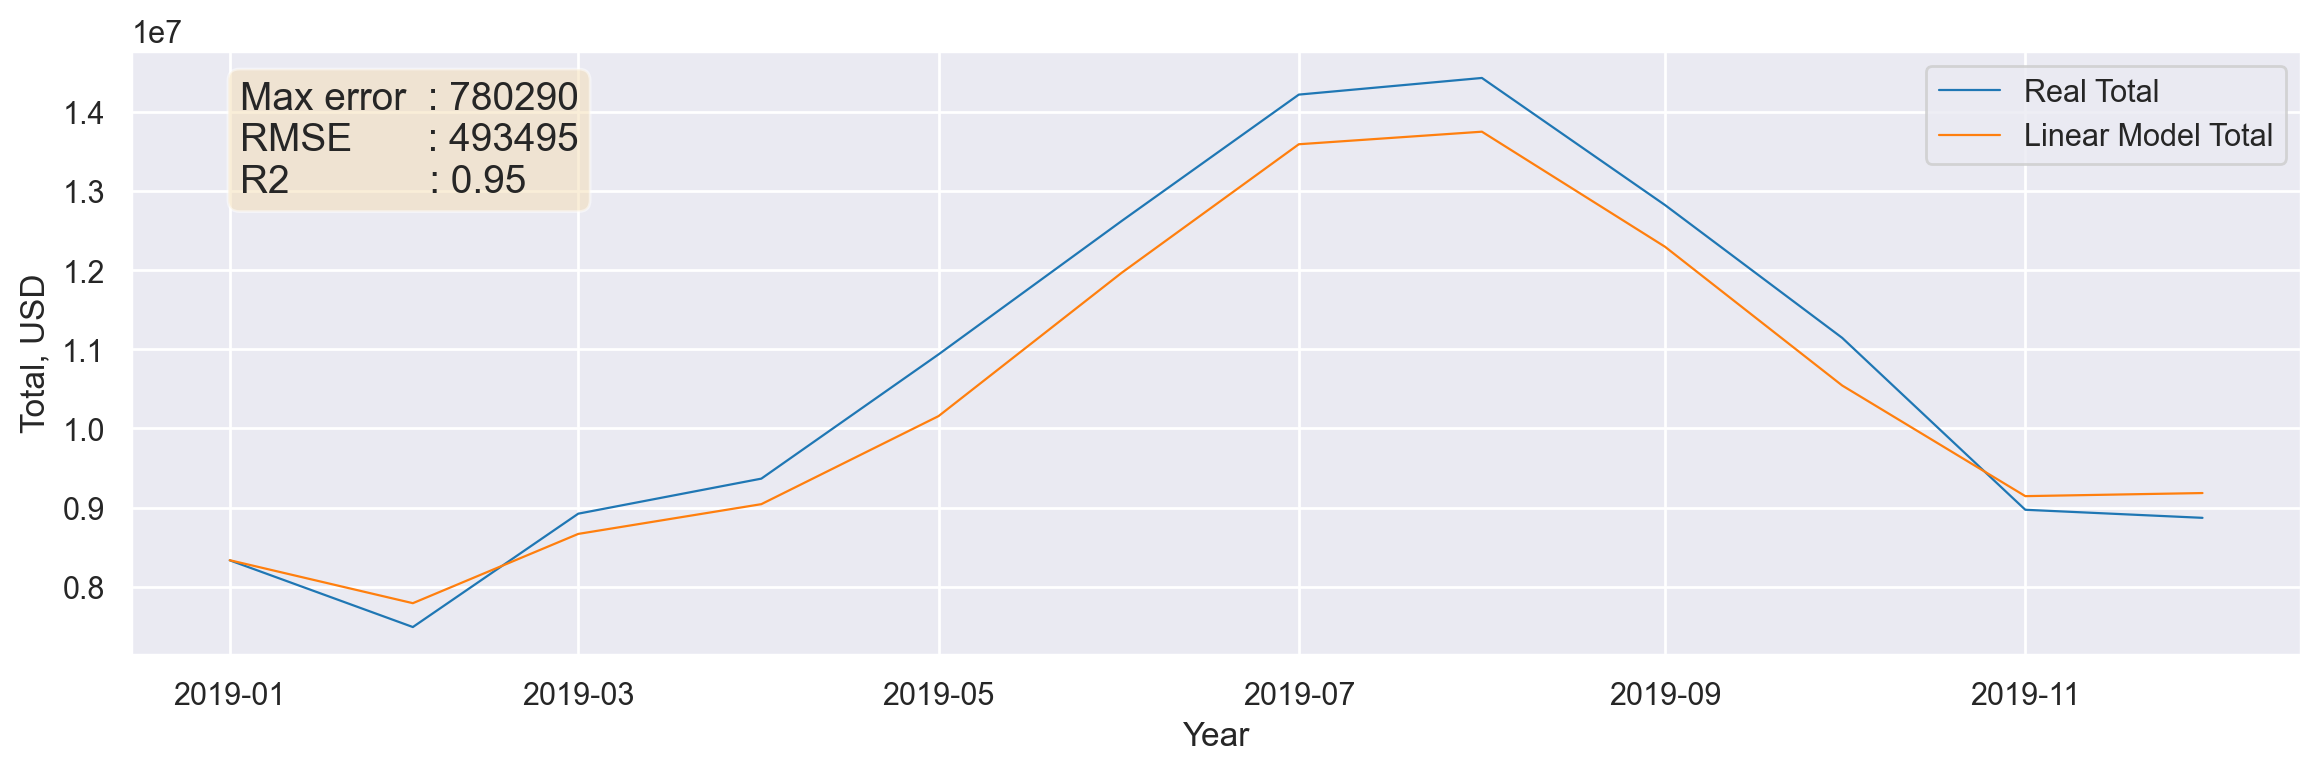

In [23]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=200)
sns.lineplot(x = df_2019.date, y = df_2019.total, linewidth=.8, label='Real Total')
sns.lineplot(x = df_2019.date, y = total_2019_pred, linewidth=.8, label='Linear Model Total')

ax.text(0.05, 0.95,
        calculate_errors(df_2019.total, total_2019_pred),
        transform=ax.transAxes, fontsize=14,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.ylabel('Total, USD')
plt.xlabel('Year')
plt.show()

---
---

## C2

По сути, полученный из линейной регрессии коэффициент наклона и свободный член позволяют делать нам предсказания на сколь угодно дальний период времени при этом демонстрируя удовлетворительную точность. Возможно данный подход можно использовать как baselane для более продвинутых моделей.

Так же можно сделать предположение, что данный подход можно усовершенствовать, если применить его для каждой отдельной группы полетов. Т.е. построить лин. регрессию для `Внутренние`, `Внешние`, `СНГ` и т.д. сложить их с соответствующей этой категории постоянной сезонностью и  далее получить `Итог`  как сумму прогнозов по каждой группе. Тут, к сожалению, мы сталкиваемся с проблемой обозначенной ранее: `Итог` на самом деле не является суммой всех остальных категорий. Протестируем эту гипотезу, но в этот раз будем ориентироваться на колонку `true_total` рассчитанную ранее.

In [24]:
def linear_model_results(df, category_name : str) -> list:     
    decomposed_ts = sm.tsa.seasonal_decompose(df[category_name], model = 'additive', freq=12)
#     one_year_pattern = decomposed_ts.seasonal.values[-12:]
    y = decomposed_ts.trend.values[6:-6]
    X = np.array((df.date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))[6:-6] # time to unix format
    slope, intercept, r_value, p_value, std_err = sp.linregress(X, y)
    X = np.array((df.date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))
    linear_fit = (slope * X) + intercept
    seasonal_part = np.tile(one_year_pattern, int(len(linear_fit) / 12))
    total_pred = linear_fit + decomposed_ts.seasonal.values
    return total_pred

In [25]:
def plot_linear_results(df, category_name : str, ax_num : int):
    st = category_name.upper()
    y_true = df[category_name]
    y_pred = linear_model_results(df, category_name)
    sns.lineplot(x = df.date, y = y_true,
                 linewidth=.8, label=f'{st} Total',
                 color='r',
                 ax=ax[ax_num])
    sns.lineplot(x = df.date, y = y_pred,
                 linewidth=.8, label=f'Linear Model {st}',color='g',
                 ax=ax[ax_num])
    
    ax[ax_num].text(0.05, 0.95,
                    calculate_errors(y_true, y_pred),
                    transform=ax[ax_num].transAxes, fontsize=14,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax[ax_num].set_ylabel(f'{st}, USD')
    ax[ax_num].set_title(f'Real {st} vs  Predicted')

#### Рассчитаем RMSE, R2 и Max Error для каждой отдельной категории и построим график позволяющий визуально сравнить спрогнозированные и реальные значения в категориях.

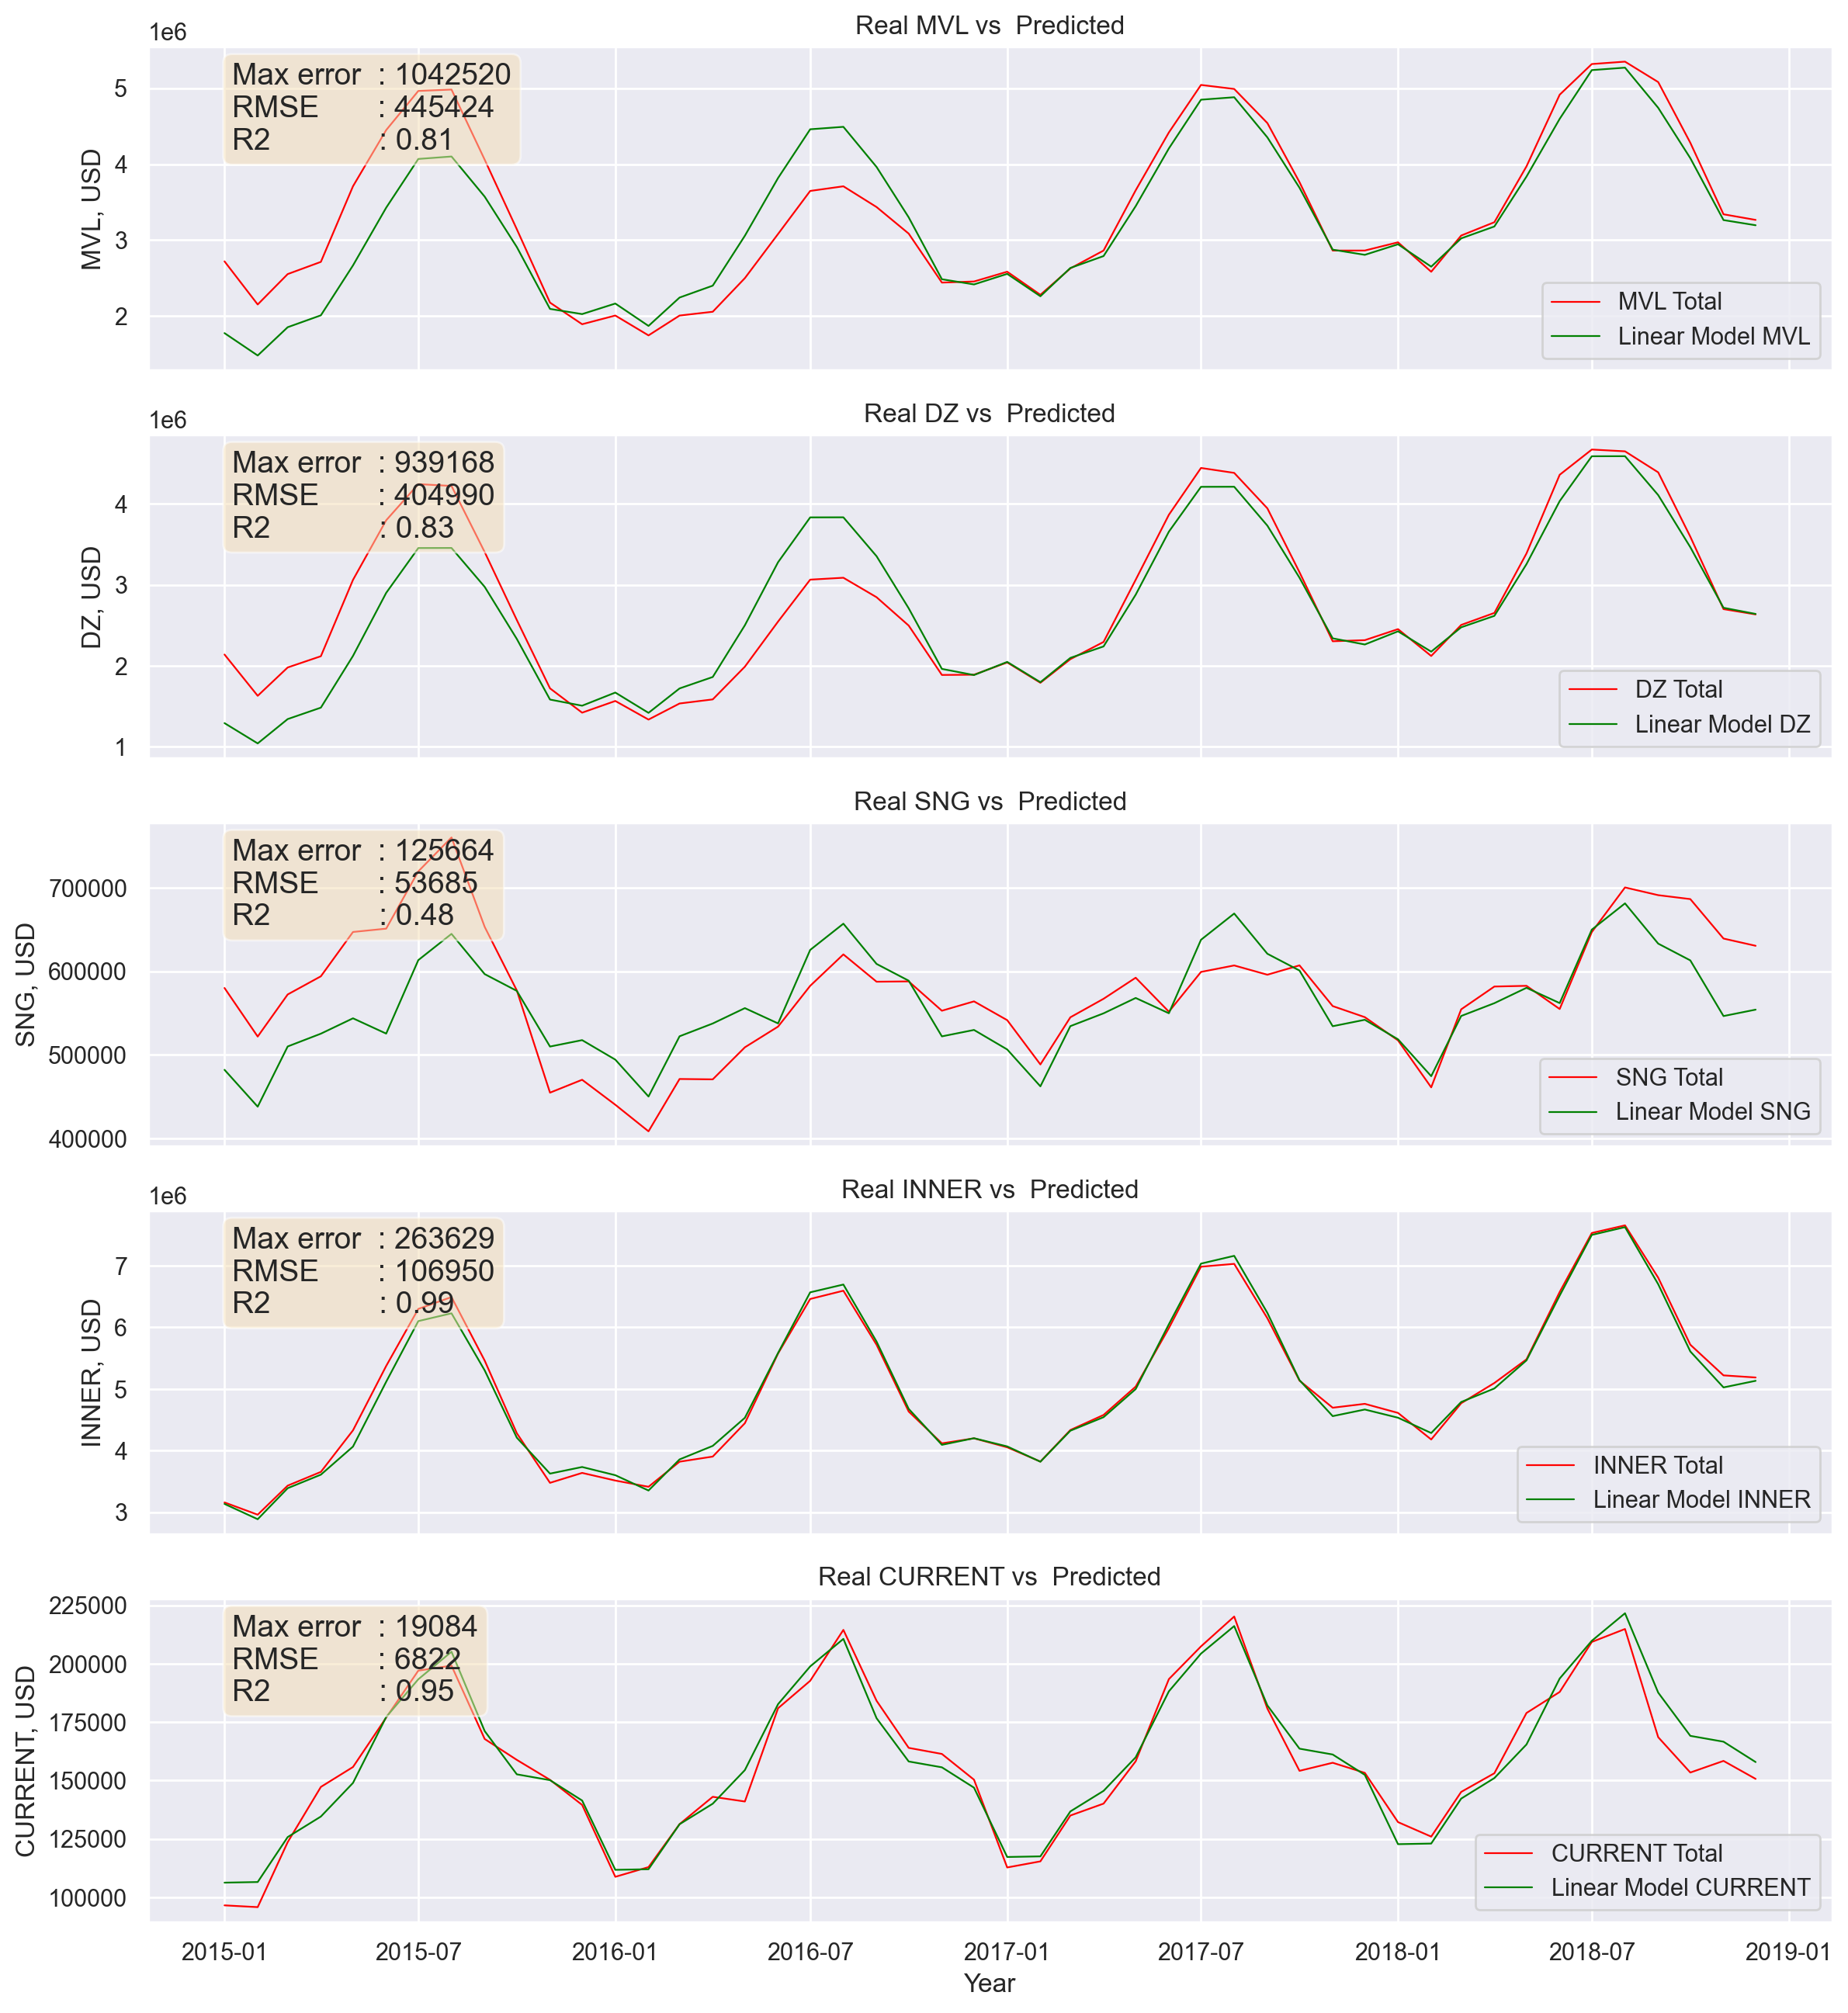

In [26]:
types_of_flight = ['mvl','dz', 'sng', 'inner', 'current']

fig, ax = plt.subplots(ncols=1, nrows = 5, figsize=(14,16), sharex=True, dpi=200)
for ax_num, type_of_flight in enumerate(types_of_flight):
    plot_linear_results(df, type_of_flight, ax_num = ax_num)
plt.xlabel('Year')
plt.show()

#### Просуммируем спрогнозированные значения из каждой категории и сравним со значением `true_total`

In [27]:
pred_real_total = sum(linear_model_results(df, i) for i in types_of_flight)

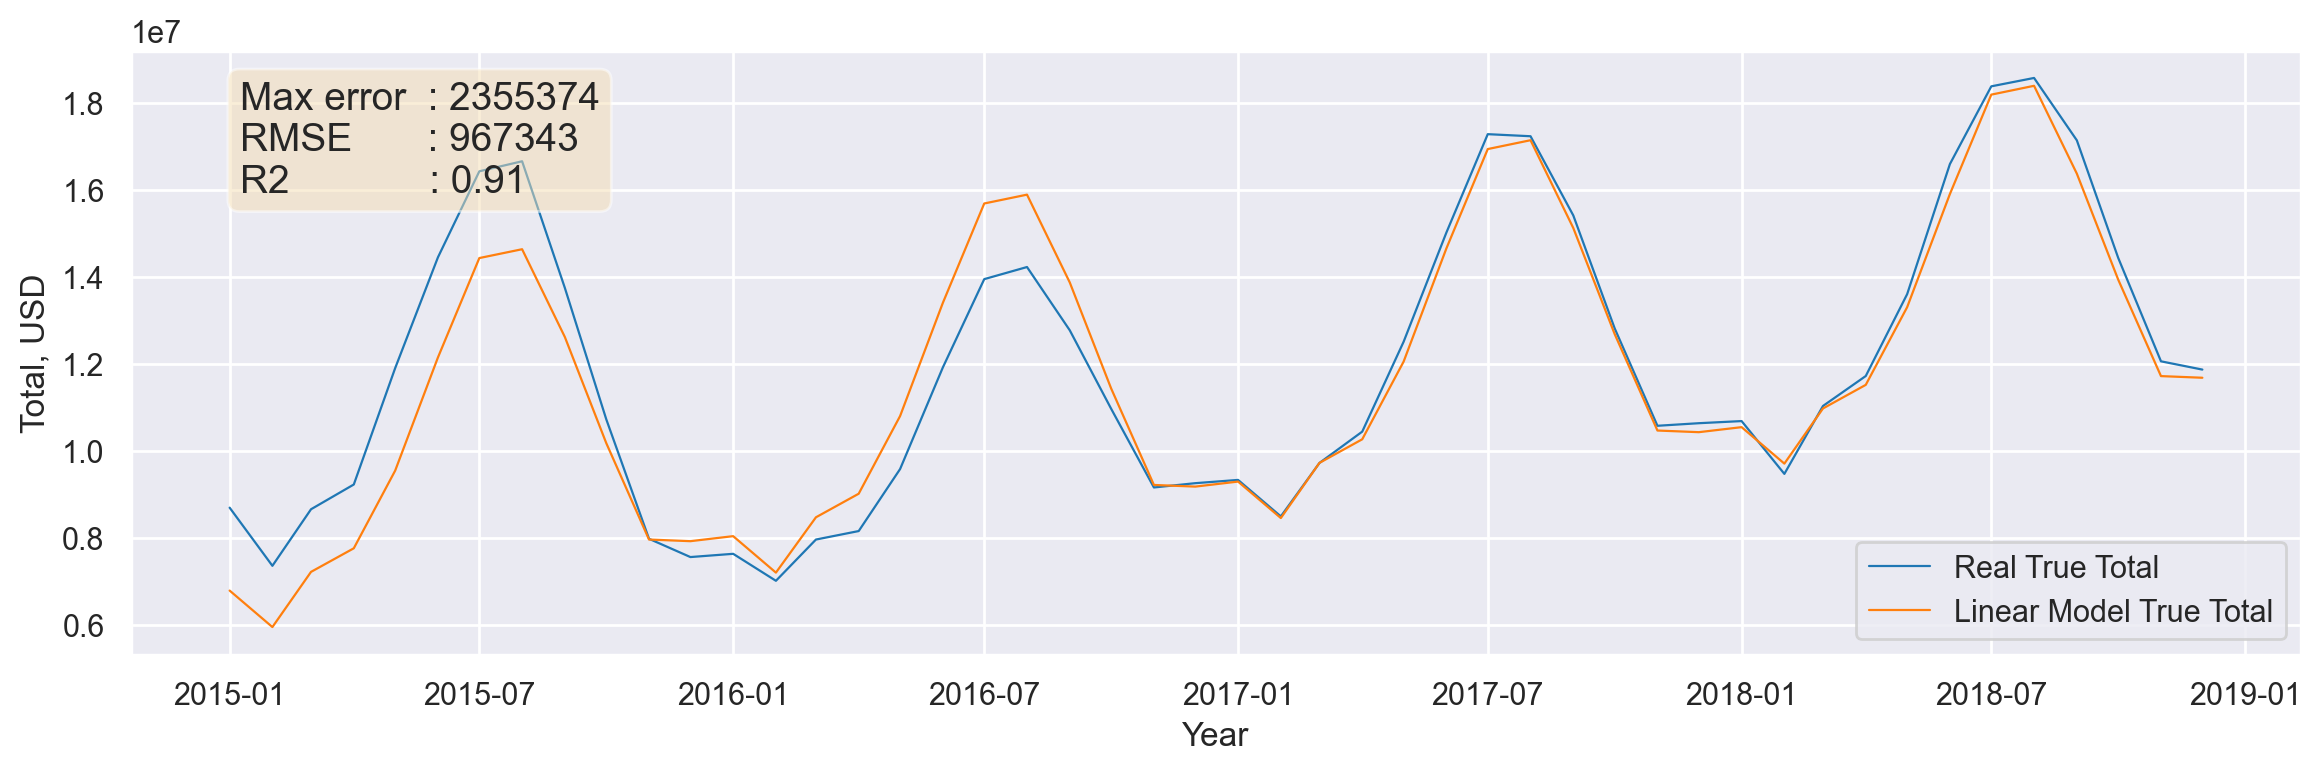

In [28]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=200)
sns.lineplot(x = df.date, y = df.true_total, linewidth=.8, label='Real True Total')
sns.lineplot(x = df.date, y = pred_real_total, linewidth=.8, label='Linear Model True Total')

ax.text(0.05, 0.95,
        calculate_errors(df.true_total, pred_real_total),
        transform=ax.transAxes, fontsize=14,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


plt.ylabel('Total, USD')
plt.xlabel('Year')
plt.show()

Как видно из значений RMSE, Max Error и R2 модель с отдельным предсказанием по каждой категории уступает предыдущей, когда предсказывалось сразу общее значение. Но стоит учесть, что в первом случае мы предсказывали `Итог`, который отличается значением от простой суммы по каждой категории. Для второй же модели мы ориентировались на `true_total`, рассчитаный именно как сумма по категориям.